In [ ]:
# MNIST experiment in NGSpice and Nengo

In [ ]:
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib
!pip install pyspice
!sudo add-apt-repository ppa:kicad/kicad-5.1-releases -y
!sudo apt-get update
!sudo apt-get install libngspice-kicad

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/kicad/kicad-5.1-releases/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1

In [ ]:
# Load the library file

from google.colab import files
uploaded =  files.upload() #upload the 180nm.lib file here

Saving 180nm.lib to 180nm (7).lib


In [ ]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
ngspice = NgSpiceShared.new_instance()
print(ngspice.exec_command('version -f'))

2021-01-05 04:39:00,728 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - spinit was not found
2021-01-05 04:39:00,730 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Note: can't find init file.
******
** ngspice-30 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Wed Feb 27 13:04:52 UTC 2019
**
** CIDER 1.b1 (CODECS simulator) included
** XSPICE extensions included
** Relevant compilation options (refer to user's manual):
** OpenMP multithreading for BSIM3, BSIM4 enabled
** X11 interface not compiled into ngspice
**
******


In [ ]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

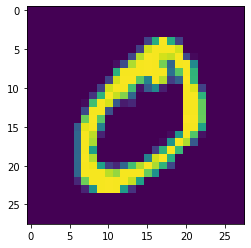

In [ ]:
## view data
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()


In [ ]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [ ]:
#parameters

n_training = 2500
n_testing = 100

n_neurons= 250
synapse=0.02
t_image=0.5
dt = 0.001

In [ ]:
neuron_model = '''
.subckt my_neuron Vmem out cvar=100p vsupply=1.8 vtau=0.4 vthr=0.2 vb=1

V1 Vdd 0 {vsupply}
V6 Vtau 0 {vtau}
V2 Vthr 0 {vthr}
V3 Vb1 0 {vb}
C1 Vmem 0 {cvar}


M5 N001 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M6 N002 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M8 N001 Vmem N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M9 N002 Vthr N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M10 N004 Vb1 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
Mreset Vmem out 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M7 N003 N002 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M18 out N003 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M19 N003 N002 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M20 out N003 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
Mleak Vmem Vtau 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2


.ends my_neuron
'''

In [ ]:
def create_neuron_netlist(N):
    # N is the number of neurons
    netlist = ''
    for i in range(N):
        netlist += 'x'+str(i)+' Vmem'+str(i)+' out'+str(i)+' my_neuron vsupply={vsource} cvar=150p vthr=0.25 \n'
        netlist += 'Rload'+str(i)+' out'+str(i)+ ' 0 100k\n'
    return netlist

In [ ]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

In [ ]:
def stim_func(t, data=x[:n_training]):
    index = int(t / t_image)
    return data[index % len(data)]

In [ ]:
time = dt*np.linspace(0, int(t_image*n_training/dt), int(t_image*n_training/dt))

In [ ]:
stim  = [stim_func(t) for t in time]

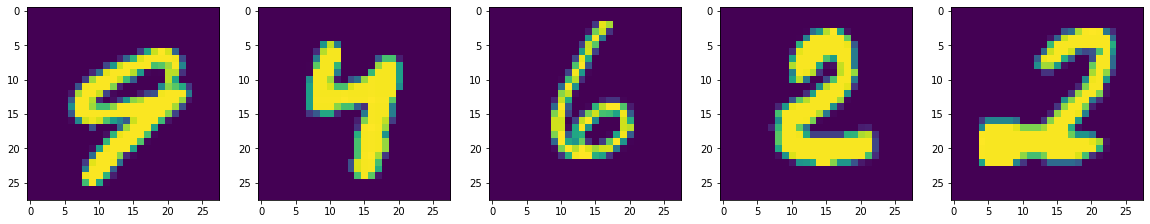

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(stim[1].reshape(28,28))
plt.subplot(152)
plt.imshow(stim[501].reshape(28,28))
plt.subplot(153)
plt.imshow(stim[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(stim[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(stim[2001].reshape(28,28))

In [ ]:
def target_func(t, data=y[:n_training]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [ ]:
target  = [target_func(t) for t in time]
#plt.plot(target)

In [ ]:
N = n_neurons  # how many neurons there are
dimensions = 784
E = np.random.normal(size=(N, dimensions))
B = np.random.normal(size=(N))*0.1

netlist_neurons = create_neuron_netlist(N)

In [ ]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

def create_neuron_current_netlist(E,B,stim,N):
    # take the A matrix and the number of neurons
    # refactor 
    netlist_input='\n'
    signal = np.zeros((len(stim), N))
    for i, J in enumerate(stim):
        if (i%1000 ==0):
           print(i)
        Js = np.dot(E, J)
        for k, JJ in enumerate(Js):
            signal[i][k] = JJ+B[k]
    print('check 0')
    
    input_signal = [[0,0] for k in range(N)]
    
    for k in range(N):
        input_signal[k] = [[i*1e-6, J*10e-6] for i, J in enumerate(signal[:,k])]
        
    print('check 1')
    for k in range(N):
        netlist_input += 'Iin'+str(k)+' Vdd Vmem'+str(k)+' PWL(' + pwl_conv(input_signal[k]) +')\n\n'
    
    return netlist_input
    

In [ ]:
## other setup parameters
args= {}
args['simulation_time'] = '1m'
args['simulation_step'] = '1u'
args['simulation_lib']  = '180nm.lib'


netlist_top= '''*Sample SPICE file
.include {simulation_lib}
.option scale=1u
.OPTIONS ABSTOL=1N VNTOL=1M.
.options savecurrents
.tran {simulation_step} {simulation_time} UIC
'''.format(**args)

netlist_bottom = '''
.end'''

In [ ]:
## define the sources
netlist_source = '''
.param vsource = 1.8
Vdd Vdd 0 {vsource}
'''

In [ ]:
netlist_inputs = create_neuron_current_netlist(E,B,stim,N)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [ ]:
def simulate(circuit):
    ngspice.load_circuit(circuit)
    ngspice.run()
    print('Plots:', ngspice.plot_names)
    plot = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
    return plot

In [ ]:
netlist = netlist_top + netlist_source + neuron_model + netlist_inputs+ netlist_neurons+ netlist_bottom
out=simulate(netlist)

In [ ]:
def extract_A_matrix(result, N, stim):
    t = np.linspace(min(out['time']._data), max(out['time']._data), len(stim))
    temp_time = out['time']._data
    inpterpolated_result = np.zeros((len(stim), N))
    A = np.zeros((len(stim), N))
    for j in range(N):
        temp_str = '@rload'+str(j)+'[i]'
        temp_out = result[temp_str]._data
        inpterpolated_result[:,j] = np.interp(t, temp_time, temp_out)
        A[:,j] = inpterpolated_result[:,j] > max(inpterpolated_result[:,j])/2
    return A
A_from_spice = extract_A_matrix(out, N, stim)
plt.figure(figsize=(12,6))
plt.imshow(A_from_spice.T, aspect='auto', cmap='gray_r')
plt.show()

In [ ]:
D, info = nengo.solvers.LstsqL2()(A_from_spice, target)

plt.plot(A_from_spice.dot(D), label='output')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

In [ ]:
filt = nengo.synapses.Lowpass(0.01) #need to implement synapses in circuit
plt.plot(filt.filt(A_from_spice.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

In [ ]:
#testing

In [ ]:
def test_x_func(t, data=x[n_training:]):
    index = int(t / t_image)
    return data[index % len(data)]

In [ ]:
time = dt*np.linspace(0, int(t_image*n_testing/dt), int(t_image*n_testing/dt))

In [ ]:
test_input  = [test_x_func(t) for t in time]

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(test_input[1].reshape(28,28))
plt.subplot(152)
plt.imshow(test_input[501].reshape(28,28))
plt.subplot(153)
plt.imshow(test_input[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(test_input[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(test_input[2001].reshape(28,28))

In [ ]:
def test_y_func(t, data=y[n_training:]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [ ]:
target  = [test_y_func(t) for t in time]

In [ ]:
netlist_inputs = create_neuron_current_netlist(E,B,test_input,N)
netlist = netlist_top + netlist_source + neuron_model + netlist_inputs+ netlist_neurons+ netlist_bottom
out=simulate(netlist)

In [ ]:
A_test = extract_A_matrix(out, N, test_input)
plt.figure(figsize=(12,6))
plt.imshow(A_test.T, aspect='auto', cmap='gray_r')
plt.show()
filt = nengo.synapses.Lowpass(0.01) #need to implement synapses in circuit
plt.plot(filt.filt(A_test.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

In [ ]:
#plt.figure(figsize=(12,6))
plt.plot(np.floor(filt.filt(A_test.dot(D))), label='output (filtered)')
plt.plot(target)

In [ ]:
output = filt.filt(A_test.dot(D))
confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)
for i in range(n_testing):
  t = (i + 1) * t_image
  index = np.argmax(time >= t) - 1
  count[target[index]] += 1
  confusion[target[index],int(output[index])] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print(score)